In [1]:
import pandas as pd
from docx import Document
import regex as re
import glob
from lxml import etree
import logging

from collections import Counter, defaultdict
import pdfplumber
import zipfile

from collections import OrderedDict

import os, sys
sys.path.insert(0, str(os.path.dirname(os.path.realpath(os.getcwd()))) + "/../miRExplore/python/")
from synonymes.GeneOntology import GeneOntology, GOTerm, GORelation, GORelationType

/home/users/joppich/.local/lib/python3.6/site-packages/pdfminer/pdfdocument.py:8: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


In [2]:
fastaSequenceMirRE = re.compile(r'^[ATCGU]{15,30}$')
mirnaFasta = re.compile(r'>.*\n[ATCGU]{15,30}$')
mirnaFastaMatch = re.compile(r'>(.*)\n([ATCGU]{15,30})\n')
fastaStartRE = re.compile(r'^>\S\S\S\S+')

In [3]:
print(fastaSequenceMirRE.search("GTGTGTTCTCTTATGTTGGTTG"))
print(fastaSequenceMirRE.search("Sequence: GTGTGTTCTCTTATGTTGGTTG"))
print(fastaSequenceMirRE.search("AUACAUGUGUGGCGUUGAUGGA"))


<regex.Match object; span=(0, 22), match='GTGTGTTCTCTTATGTTGGTTG'>
None
<regex.Match object; span=(0, 22), match='AUACAUGUGUGGCGUUGAUGGA'>


In [4]:
print(mirnaFasta.search("""
521_94_22_3p cand1

>seq_3430 22 bp
GAAAUACCAGUGGCUUACCGCA"""))

<regex.Match object; span=(21, 59), match='>seq_3430 22 bp\nGAAAUACCAGUGGCUUACCGCA'>


In [5]:
print(mirnaFastaMatch.findall("""
521_94_22_3p cand1

>seq_3430 22 bp
GAAAUACCAGUGGCUUACCGCA
>seq_3431 22 bp
GAAAUACCAGUGGCUUACCGCA
asdasd"""))

[('seq_3430 22 bp', 'GAAAUACCAGUGGCUUACCGCA'), ('seq_3431 22 bp', 'GAAAUACCAGUGGCUUACCGCA')]


In [6]:
class DocumentMirnaSequence:

    def __init__(self, seqid, seq, source=None):

        self.mirna_id = seqid.replace("  ", " ").replace(" ", "_").replace(".", "_")
        self.mirna_seq = seq
        self.origin = []
        self.source = source
        self.bestmatches  = {}

    def add_origin(self, neworigin):
        if not neworigin in self.origin:
            self.origin.append(str(neworigin))

    def to_fasta(self):
        return ">{}\n{}".format(self.mirna_id, self.mirna_seq.replace("U", "T"))

    def __str__(self):
        return "{} {} {} {}".format(self.mirna_id, self.mirna_seq, self.source, ",".join(self.origin))

    def __repr__(self):
        return "<{}/>".format(self.__str__())

    def __eq__(self, other):
        return isinstance(other, DocumentMirnaSequence) and self.source==other.source and self.mirna_id == other.mirna_id and self.mirna_seq == other.mirna_seq and tuple(self.origin) == tuple(other.origin)
    
    def __ne__(self, other):
        return not self.__eq__(other)

    def __hash__(self):
        return hash(self.mirna_id) + hash(self.mirna_seq) + hash(tuple(self.origin)) + hash(self.source)

In [7]:
def is_empty(elem):
    if elem is None:
        return True

    if len(str(elem)) == 0:
        return True

    return False

def test_substrings_included(word, substrs):
    for x in substrs:
        if x in word:
            return True
    return False

def get_sequence(word):
    mirSequence = str(word).replace("Sequence: ", "").strip()
    mirSequence = re.sub(r"^[\s0-9]+","",mirSequence)

    return mirSequence

def test_is_sequence( word):
    mirSequence = get_sequence(word)
    match = fastaSequenceMirRE.search(mirSequence)

    if match:
        return True

    match = mirnaFasta.search(mirSequence)
    if match:
        return True

    return False
    
def hasSeqColumn(df, num_tests=10):
    hasSeqColumns = False
    for i in range(df.shape[1]):
        isSeqCol = column_contains_mirnas(df, 0, i, num_tests=num_tests)
        #print("col", i, isSeqCol)
        hasSeqColumns = hasSeqColumns or isSeqCol

    return hasSeqColumns

def column_contains_mirnacells(df, indexRow, xi, num_tests=10):
    

    foundSeqs = 0
    for ri, row in df.loc[indexRow+1:min(num_tests, df.shape[0]),].iterrows():
        
        cellContent = str(row[xi])

        #print('"'+cellContent+'"')
        #print(mirnaFasta.search(cellContent))

        if mirnaFasta.search(cellContent):
            foundSeqs += 1

    if foundSeqs > 0:
        return True

    #print("[column_contains_mirnacells] Column", xi, "is not a valid miRNA Sequence", foundSeqs)
    return False

def column_contains_mirnas(df, indexRow, xi, num_tests=10):

    foundSeqs = 0
    testedSeqs = 0
    for ri, row in df.loc[indexRow+1:min(num_tests, df.shape[0]),].iterrows():
        
        word = str(row[xi])

        #print(word, test_is_sequence(word))
        if not is_empty(word):
            testedSeqs+= 1

        if test_is_sequence(word):
            foundSeqs += 1
        #else:
        #    print("F", word)

    if testedSeqs>0 and foundSeqs/testedSeqs > 0.8:
        return True

    #print("[column_contains_mirnas] Column", xi, "is not a valid miRNA Sequence", foundSeqs, testedSeqs)
    return False

def column_contains_highlighted_mirnas(table, indexRow, xi):

    foundSeqs = 0
    testedSeqs = 0
    for ri, row in enumerate(table.rows):
        
        if ri <= indexRow:
            continue

        for par in row.cells[xi].paragraphs:
            cellWasFilled = False
            mirnaWasFound = False

            for run in par.runs:

                specialText = bool(run.underline) or bool(run.bold) or bool(run.italic)

                if not is_empty(run.text):
                    cellWasFilled = True
                
                if specialText and test_is_sequence(run.text):
                    mirnaWasFound = True

            if cellWasFilled:
                testedSeqs += 1

            if mirnaWasFound: 
                foundSeqs += 1
        
    if  testedSeqs>0 and foundSeqs/testedSeqs > 0.8:
        return True

    print("[column_contains_highlighted_mirnas] Column", xi, "is not a valid miRNA Sequence", foundSeqs)
    return False

def getNameSeqColumns(df, table=None, num_tests=20):

    origDF = df.copy()

    for rowstart in range(0,5):

        df = origDF.copy()
        df = df.iloc[rowstart:]

        if 0 in df.shape:
            continue

        indexRow = 0
        for i in range(0, min(10, df.shape[0])):
            idxCnt = Counter(["str" if not pd.isna(x) and not x == "nan" else "NAN" for x in df.iloc[i]])
            #print(i,idxCnt)
            if idxCnt.most_common(1)[0][0] == "str":
                indexRow = i
                break

        #print(indexRow)
        potentialColumns = list(df.iloc[indexRow,])
        potentialColumns = [str(x).strip() for x in potentialColumns]
        #print("S", rowstart, potentialColumns)
        
        mirName = None
        mirSeq = None
        mirReason = None

        mirFounds = []

        for xi, x in enumerate(potentialColumns):
            if test_substrings_included(x.upper(), ["NAME","ACCESSION", "MATURE MIRNA", "MIRNA"]) and not test_substrings_included(x.upper(), ["TARGET GENE", "PROTEIN", "GENE"]) and not column_contains_mirnas(df, indexRow, xi, num_tests=num_tests):
                mirName = xi
                print("set mirName", mirName, mirSeq, potentialColumns[xi])

            elif test_substrings_included(x.upper(), ["MIRNA SEQUENCE","MATURE SEQUENCE", "SEQUENCE OF MATURE", "SEQUENCE", "5P MIRNA", "3P MIRNA"]) and not test_substrings_included(x.upper(), ["PRIMER"]) and column_contains_mirnas(df, indexRow, xi, num_tests=num_tests) and mirSeq is None:

                mirSeq = xi
                mirReason = "SEQ_COLUMN"
                print("set mirSeq", mirName, mirSeq, potentialColumns[xi])
                
            elif test_substrings_included(x.upper(), ["MIRNA"]) and column_contains_mirnacells(df, indexRow, xi, num_tests=num_tests) and mirSeq is None:
                mirSeq = xi
                mirName = xi
                mirReason = "FASTA_COLUMN"

            elif not table is None and test_substrings_included(x.upper(), ["PRECURSOR SEQUENCE", "MIRNA SEQUENCE","MATURE SEQUENCE", "SEQUENCE OF MATURE", "SEQUENCE"]) and column_contains_highlighted_mirnas(table, indexRow, xi) and mirSeq is None:
                mirSeq = xi
                mirReason = "HIGHLIGHT_COLUMN"

            if mirSeq != None and mirName != None:

                mirFounds.append((mirName, mirSeq, mirReason))

                #mirName = None
                mirSeq = None
                mirReason = None


        if mirName is None and mirSeq is None:
            #print(potentialColumns)

            for xi, x in enumerate(potentialColumns):

                if test_substrings_included(x.upper(), ["MIRNA", "MIRNA SEQUENCE","MATURE SEQUENCE", "SEQUENCE OF MATURE", "SEQUENCE"]) and column_contains_mirnas(df, indexRow, xi, num_tests=num_tests) and mirSeq is None:

                    mirSeq = xi
                    mirName = xi
                    mirReason = "NAME_SEQ_COLUMN"

                if mirSeq != None and mirName != None:

                    mirFounds.append((mirName, mirSeq, mirReason))
                    mirName = None
                    mirSeq = None
                    mirReason = None



        if len(mirFounds) > 0:
            for mirName, mirSeq, mirReason in mirFounds:
                print("Name:", mirName, potentialColumns[mirName] if mirName != None else "")
                print("Seq: ", mirSeq, potentialColumns[mirSeq] if mirSeq != None else "")
                print("Reason: ", mirReason)

            return indexRow, mirFounds

    print(mirFounds)
    for mirName, mirSeq, mirReason in mirFounds:
        print("Name:", mirName, potentialColumns[mirName] if mirName != None else "")
        print("Seq: ", mirSeq, potentialColumns[mirSeq] if mirSeq != None else "")
        print("Reason: ", mirReason)

    return indexRow, mirFounds

In [8]:
test_is_sequence("AUACAUGUGUGGCGUUGAUGGA")

True

In [9]:
def extract_mirnas_from_document(infile):

    identified_mirnas = set()

    document = Document(infile)
    docTables = {}
    for table in document.tables:
        data = [[cell.text for cell in row.cells] for row in table.rows]
        df = pd.DataFrame(data)
        docTables[len(docTables)] = df
        
        identified_mirnas = identified_mirnas.union(extract_mirnas_from_pandas_tabledf( df, table ))

    return docTables,identified_mirnas



In [10]:
def extract_mirnas_from_pandas_tabledf( df, table=None, num_tests=10):
    startRow, mirFounds = getNameSeqColumns(df, table, num_tests)

    identified_mirnas = set()
    
    for mirName, mirSeq, mirReason in mirFounds:

        print(mirSeq, mirName, mirReason)
        if mirName == None or mirSeq == None:
            print("Skipping")
            print(startRow, mirName, mirSeq)
            continue



        if mirReason == "SEQ_COLUMN":

            for ri, row in df.loc[startRow:,].iterrows():

                mirSeqText = str(row[mirSeq])
                mirNameText = str(row[mirName])

                if not is_empty(mirSeqText) and not is_empty(mirSeqText):
                    mirSequence = get_sequence(mirSeqText)

                    if test_is_sequence(mirSeqText):
                        #print(mirNameText, mirSequence)
                        identified_mirnas.add( DocumentMirnaSequence(mirNameText, mirSequence, source="SEQ_COLUMN") )

        elif mirReason == "FASTA_COLUMN":

            for ri, row in df.loc[startRow:,].iterrows():
                cellContent = str(row[mirSeq])
                if mirnaFasta.search(cellContent):
                    for mirNameText, mirSequence in mirnaFastaMatch.findall(cellContent):
                        identified_mirnas.add( DocumentMirnaSequence(mirNameText, mirSequence, source="FASTA_COLUMN") )

        elif mirReason == "HIGHLIGHT_COLUMN":

            for ri, row in enumerate(table.rows):
        
                if ri <= startRow:
                    continue

                mirNameText = str(row.cells[mirName].text)

                cellMirnaCount = 0
                for par in row.cells[mirSeq].paragraphs:
                    cellWasFilled = False
                    mirnaWasFound = False

                    for run in par.runs:

                        specialText = bool(run.underline) or bool(run.bold) or bool(run.italic)

                        if not is_empty(run.text):
                            cellWasFilled = True
                        
                        runText = get_sequence(run.text)

                        if specialText and test_is_sequence(run.text):
                            identified_mirnas.add( DocumentMirnaSequence("{}_{}".format(mirNameText, cellMirnaCount), runText, source="HIGHLIGHT_COLUMN") )
                            cellMirnaCount += 1

        elif mirReason == "NAME_SEQ_COLUMN":

            mirSeqSequence = 0
            for ri, row in df.loc[startRow:,].iterrows():

                mirSeqText = str(row[mirSeq])

                if not is_empty(mirSeqText) and not is_empty(mirSeqText):
                    mirSequence = get_sequence(mirSeqText)

                    if test_is_sequence(mirSeqText):
                        #print(mirNameText, mirSequence)
                        identified_mirnas.add( DocumentMirnaSequence("miRNA_{}".format(mirSeqSequence), mirSequence, source="NAME_SEQ_COLUMN") )
                        mirSeqSequence += 1

        else:
            raise ValueError("Unknown mirReason")
       
    return identified_mirnas

In [11]:
def extract_mirnas_from_excel(infile):
    try:
        sheetsDF = pd.read_excel(infile, header=None, sheet_name=None, engine='openpyxl')
        print("Sheets", [x for x in sheetsDF])
    except:
        logging.error("Error loading file EXCEL: {}".format(infile))

        return None, None
    #columns is empty!

    identified_mirnas = extract_mirnas_sheetsdf(sheetsDF)
    return sheetsDF, identified_mirnas

In [12]:
def extract_mirnas_from_pdf(infile):
    pdfDFs = {}

    try:
        pdf = pdfplumber.open(infile)
    except:
        logging.error("Error loading file PDF: {}".format(infile))
        return None, None

    extractionSettings = OrderedDict()
    extractionSettings["loose"] = {
                "vertical_strategy": "text", 
                "horizontal_strategy": "lines",
                #"snap_tolerance": 3,
                "snap_x_tolerance": 5,
                "snap_y_tolerance": 3,
                "join_x_tolerance": 5,
                "join_y_tolerance": 3,
                "edge_min_length": 3,
                "min_words_vertical": 3,
                "min_words_horizontal": 5,
                "keep_blank_chars": False,
                "text_x_tolerance": 5,
                "text_y_tolerance": 3,
                "intersection_x_tolerance": 5,
                "intersection_y_tolerance": 3,
                }
    extractionSettings["tight"] = {
            "vertical_strategy": "text", 
            "horizontal_strategy": "text",
            "snap_x_tolerance": 1,
            "snap_y_tolerance": 5,
            "join_x_tolerance": 1,
            "join_y_tolerance": 3,
            "edge_min_length": 3,
            "min_words_vertical": 3,
            "min_words_horizontal": 1,
            "keep_blank_chars": False,
            "text_x_tolerance": 1,
            "text_y_tolerance": 3,
            "intersection_x_tolerance": 1,
            "intersection_y_tolerance": 3,
        }


    pdfDFs = {}

    for eSetting in extractionSettings:
        #print(eSetting)
        for page in pdf.pages:
        
            curRow = None
            tableRows = []

            for table in page.extract_tables(extractionSettings[eSetting]):
                for row in table:
                    #print("R", row)
                    
                    if row[0] != None:

                        if curRow != None:
                            curRow = [x.replace("\n", "") if not x is None else "" for x in curRow]
                            tableRows.append(curRow)

                        curRow = row
                        continue

                    if not curRow is None:
                        for xi in range(0, len(curRow)):
                            if row != None and row[xi] != None:

                                if curRow[xi] is None:
                                    curRow[xi] = row[xi]
                                else:
                                    curRow[xi] += "\n" + row[xi]
                    

            pageDF = pd.DataFrame(tableRows)

            if not 0 in pageDF.shape:

                
                if page.page_number in pdfDFs:

                    #print(page.page_number)

                    pageHasSeqCol = hasSeqColumn(pageDF, num_tests=20)
                    existHasSeqCol = hasSeqColumn(pdfDFs[page.page_number], num_tests=20)

                    if pageHasSeqCol and not existHasSeqCol:
                        #print("Replacing PageDF", page.page_number)
                        pass
                    elif pageHasSeqCol and pdfDFs[page.page_number].shape[0] * pdfDFs[page.page_number].shape[1] < pageDF.shape[0]*pageDF.shape[1]:
                        #print("Replacing PageDF", page.page_number)
                        pass
                    else:
                        continue

                pdfDFs[page.page_number] = pageDF



    identified_mirnas = extract_mirnas_sheetsdf(pdfDFs, num_tests=20)

    return pdfDFs, identified_mirnas

In [13]:
def extract_mirnas_from_xml(infile):

    try:
        tree = etree.parse(infile)
    except:
        logging.error("Error loading file XML: {}".format(infile))
        return None, None

    tree = etree.parse(infile)
    tables = tree.findall("//table")

    sheetsDF = {}
    for ti, table in enumerate(tables):
        dfs = pd.read_html(etree.tostring(table,method='html'))

        for tii, tdf in enumerate(dfs):
            tname = "Table{}.{}".format(ti, tii)

            fracStrCols = sum([1 if type(x) == str else 0 for x in tdf.columns])/len(tdf.columns)
            
            if fracStrCols > 0 or isinstance(tdf.columns, pd.MultiIndex):
                #print("Removing Columns")
                #print(type(tdf.columns))
                if isinstance(tdf.columns, pd.MultiIndex):
                    #print("Fixing Columns")

                    lvlValues = [""] * len(tdf.columns.get_level_values(0))

                    for x in range(0, len(tdf.columns.levels)):

                        levelValues = tdf.columns.get_level_values(x)

                        if len(set(levelValues)) == 1:
                            continue

                        for vi, v in enumerate(levelValues):

                            if v in lvlValues[vi]:
                                continue

                            if len(lvlValues[vi]) > 0:
                                lvlValues[vi] += " "
                            lvlValues[vi] += v

                    print(lvlValues)

                    tdf.columns = list(tdf.columns.get_level_values(len(tdf.columns.levels)-1))
                    #print(tdf.columns)
                    
                tdf = tdf.T.reset_index().T.reset_index(drop=True)

            sheetsDF[tname] = tdf

            #print(tname)
            #print(tdf)

    print("Sheets", [x for x in sheetsDF])

    identified_mirnas = extract_mirnas_sheetsdf(sheetsDF)

    return sheetsDF, identified_mirnas

In [14]:
def extract_mirnas_sheetsdf(sheetsDF, num_tests=10):

    if len(sheetsDF) == 0:
        return

    identified_mirnas = set()

    print("Testing FASTA")
    identified_mirnas = identified_mirnas.union(extract_mirnas_from_pandas_fasta(sheetsDF))
    print("Testing COLUMNS")
    identified_mirnas = identified_mirnas.union(extract_mirnas_from_pandas_table(sheetsDF, num_tests=num_tests))

    return identified_mirnas

In [15]:
def extract_mirnas_from_pandas_table(sheetsDF, num_tests=10):
    identified_mirnas = set()
    for sheet in sheetsDF:

        df = sheetsDF[sheet]
        print(sheet, df.shape)
        if 0 in df.shape:
            print("Skipping sheet", sheet)
            continue

        identified_mirnas = identified_mirnas.union(extract_mirnas_from_pandas_tabledf( df, num_tests=num_tests))
    return identified_mirnas

In [16]:
def extract_mirnas_from_pandas_fasta(sheetsDF):
    identified_mirnas = set()
    for sheet in sheetsDF:

        df = sheetsDF[sheet]

        for column in df.columns:

            #print("Testing col", column)

            bestRowSequence = None
            rowSequence = []
            
            for rowIdx, row in df.iterrows():

                fastaStart = fastaStartRE.search(str(row[column]))
                fastaSequenceMir = fastaSequenceMirRE.search(str(row[column]))

                if fastaStart:
                    #print(rowIdx, "fasta start")
                    rowSequence.append("start")
                if fastaSequenceMir:
                    #print(rowIdx, "fasta seq")
                    rowSequence.append("seq")

                if not fastaStart and not fastaSequenceMir:
                    if len(rowSequence) > 0 and (bestRowSequence == None or len(bestRowSequence) > len(rowSequence)):
                        bestRowSequence = rowSequence

                if rowIdx > 20:
                    break
            if len(rowSequence) > 0 and (bestRowSequence == None or len(bestRowSequence) > len(rowSequence)):
                bestRowSequence = rowSequence

            if not bestRowSequence is None:

                count = 0
                bestCount = 0
                for i in range(1, len(bestRowSequence)):

                    if bestRowSequence[i-1] != bestRowSequence[i]:
                        count += 1

                    else:
                        if count > bestCount:
                            bestCount = count

                if count > bestCount:
                            bestCount = count

                if bestCount > 0:
                    print(sheet, column, bestRowSequence)
                    print(sheet, column, bestCount)

                    # extract mirnas

                    startName = None
                    startSeq = None

                    for rowIdx, row in df.iterrows():

                        rowSeq = str(row[column])
                        fastaStart = fastaStartRE.search(rowSeq)
                        fastaSequenceMir = fastaSequenceMirRE.search(rowSeq)

                        if fastaStart:
                            #print(rowIdx, "fasta start")
                            startName = rowSeq[1:]
                        if fastaSequenceMir:
                            #print(rowIdx, "fasta seq")
                            startSeq = rowSeq

                        if not startSeq is None and not startName is None:
                            newMir = DocumentMirnaSequence(startName, startSeq, source="FASTA_COLUMN")
                            identified_mirnas.add(newMir)

                            startName = None
                            startSeq = None
                    
    return identified_mirnas

In [17]:
sheetsdf = pd.read_excel("/mnt/raidtmp/joppich/pubmed_pmc/pmc/vimtm/covidsents/PMC7381279/PMC7381279_Data_Sheet_3.XLSX", header=None, sheet_name=None, engine="openpyxl")
sheetsdf = pd.read_excel("/mnt/raidtmp/joppich/pubmed_pmc/pmc/vimtm/covidsents/PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/767726_SupMaterial/Supplementary File1.xlsx", header=None, sheet_name=None, engine="openpyxl")

extract_mirnas_from_pandas_fasta(sheetsdf)

set()

In [18]:
def find_relevant_files(infolders):

    if not isinstance(infolders, list):
        infolders = [infolders]

    relFiles = []
    for folder in infolders:
        for path, subdirs, files in os.walk(folder):
            for name in files:
                if name.upper().endswith(("XML", "XLSX", "DOCX", "PDF", "ZIP")):
                    relFiles.append( os.path.join(path, name) )

    return relFiles

all_relevant_files = find_relevant_files(["./", "../covidtexts/"])
all_relevant_files


['./test.pdf',
 './PMC8733928/PMC8733928_DataSheet_1.zip',
 './PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/767726_SupMaterial/Supplementary File1.xlsx',
 './PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/767726_SupMaterial/Supplementary File2.xlsx',
 './PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/767726_SupMaterial/Supplementary File3.xlsx',
 './PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/767726_SupMaterial/Supplementary File4.xlsx',
 './PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/767726_SupMaterial/Supplementary File5.xlsx',
 './PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/767726_SupMaterial/Supplementary File6.pdf',
 './PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/767726_SupMaterial/Supplementary File7.xlsx',
 './PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/767726_SupMaterial/Supplementary File8.xlsx',
 './PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/__MACOSX/767726_SupMaterial/._Cove

In [19]:
def merge_mirnas(exmirnas, newmirnas, fileid):

    if newmirnas is None or len(newmirnas) == 0:
        return exmirnas

    fileidPMC = fileid.split("_")[0]
    if fileidPMC.startswith("PMC"):
        fileidPMC = fileidPMC.split(".")[0]
        fileid = fileidPMC

    emirnas = set()
    for x in newmirnas:
        x.add_origin(fileid)
        exmirnas.add(x)
        
    return exmirnas

def merge_sdf(exsdf, newsdf, fileid):

    if newsdf == None or len(newsdf) == 0:
        return exsdf

    exsdf[fileid] = newsdf
    return exsdf

def process_files(infiles):
    found_tables = {}
    identified_mirnas = set()
    for infile in infiles:
        print()
        print()
        print()
        print(infile)

        if "MACOS" in infile:
            logging.warn("Skipping MACOSX file {}".format(infile))
            continue

        sdf = None
        idmirnas = None

        docID = os.path.splitext(os.path.basename(infile))[0]
        
        for foldername in reversed(os.path.dirname(infile).split("/")):
            if foldername.startswith("PMC"):
                docID = foldername.split("_")[0]
                break

        if infile.upper().endswith(".XLSX"):
            sdf, idmirnas = extract_mirnas_from_excel(infile)

            if not idmirnas is None:
                identified_mirnas = identified_mirnas.union(idmirnas)

        elif infile.upper().endswith(".XML"):
            sdf, idmirnas = extract_mirnas_from_xml(infile)

            if not idmirnas is None:
                identified_mirnas = identified_mirnas.union(idmirnas)

        elif infile.upper().endswith(".PDF"):
            sdf, idmirnas = extract_mirnas_from_pdf(infile)
            if not idmirnas is None:
                identified_mirnas = identified_mirnas.union(idmirnas)

        elif infile.upper().endswith(".DOCX"):
            sdf, idmirnas = extract_mirnas_from_document(infile)

            if not idmirnas is None:
                identified_mirnas = identified_mirnas.union(idmirnas)

        elif infile.upper().endswith(".ZIP"):

            continue

            outfolder = os.path.dirname(infile) + "/" + os.path.splitext(os.path.basename(infile))[0]
            print("Outfolder", outfolder)

            try:
                with zipfile.ZipFile(infile) as z:
                    z.extractall(outfolder)
            except:
                print("Invalid file")

            sdf, idmirnas = process_files(find_relevant_files(outfolder))
            
        
        identified_mirnas = merge_mirnas(identified_mirnas, idmirnas, docID)
        found_tables = merge_sdf(found_tables, sdf, docID )


    return sdf, identified_mirnas
    

sdf, identified_mirnas = process_files(all_relevant_files)

#sdf, identified_mirnas = process_files(["../covidtexts/PMC7278893.xml"])





./test.pdf
Testing FASTA
Testing COLUMNS
1 (8, 3)
[]



./PMC8733928/PMC8733928_DataSheet_1.zip



./PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/767726_SupMaterial/Supplementary File1.xlsx
Sheets ['SCV2-miRNA sequence', 'Primer of miRNA', 'Primer of target']
Testing FASTA
Testing COLUMNS
SCV2-miRNA sequence (8, 5)
set mirName 0 None Pre-miRNA name
set mirName 0 None Pre-miRNA name
[]
Primer of miRNA (32, 4)
set mirName 0 None Primer names
set mirName 0 None Primer names
set mirName 0 None Primer names
[]
Primer of target (21, 2)
set mirName 0 None Primer names
[]



./PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/767726_SupMaterial/Supplementary File2.xlsx
Sheets ['Sheet1']
Testing FASTA
Testing COLUMNS
Sheet1 (32, 10)
set mirName 0 None Accession number
set mirName 1 None Strain Name
set mirName 3 None Name in Graph
[]



./PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/767726_SupMaterial/Supplementary File3.xlsx
Sheets ['Sheet1']
Testing FASTA
Testin

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


Sheets ['Sheet1']
Testing FASTA
Testing COLUMNS
Sheet1 (1032, 12)
[]



./PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/__MACOSX/767726_SupMaterial/._Cover letter.PDF



./PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/__MACOSX/767726_SupMaterial/._SARS-C...le gene-1126.docx



./PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/__MACOSX/767726_SupMaterial/._Supplementary File1.xlsx



./PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/__MACOSX/767726_SupMaterial/._Supplementary File2.xlsx



./PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/__MACOSX/767726_SupMaterial/._Supplementary File3.xlsx



./PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/__MACOSX/767726_SupMaterial/._Supplementary File4.xlsx



./PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/__MACOSX/767726_SupMaterial/._Supplementary File5.xlsx



./PMC8733928/PMC8733928_DataSheet_1/767726_SupMaterial(1)/__MACOSX/767726_SupMaterial/._Supplementary File6.pdf



./PMC87

ERROR:root:Error loading file XML: ./PMC7395633/PMC7395633_mmc1/Data Profile.xml


set mirName 0 None SARS-CoV2 miRNA
set mirName 1 None Human miRNA
[]
set mirName 0 None miRNA (SARS-CoV2)
set mirName 1 None miRNA (Human)
[]



./PMC7395633/PMC7395633_mmc1/Data Profile.xml



./PMC8307234/PMC8307234_cells-10-01762-s001.zip



./PMC8307234/PMC8307234_cells-10-01762-s001/cells-1268410-supplementary.pdf
Testing FASTA
Testing COLUMNS
1 (45, 7)
set mirSeq None 3 Sequences (5’ ‐> 3’)
[]
3 (51, 7)
set mirName 2 None v‐miRNAs
set mirName 0 None V‐miRNA1
set mirSeq 0 3 Size  Sequence 5’‐>3’
Name: 0 V‐miRNA1
Seq:  3 Size  Sequence 5’‐>3’
Reason:  SEQ_COLUMN
3 0 SEQ_COLUMN
4 (15, 6)
[]
2 (10, 5)
[]
5 (16, 2)
[]



./PMC8078050/PMC8078050_mmc1.docx
set mirSeq None 0 Predicted miRNA sequences
set mirName 2 0 Name of miRNA
Name: 2 Name of miRNA
Seq:  0 Predicted miRNA sequences
Reason:  SEQ_COLUMN
0 2 SEQ_COLUMN



./PMC8078050/PMC8078050_mmc2.docx
set mirName 0 None Predicted miRNA sequences
set mirName 1 None Name of miRNA
[column_contains_highlighted_mirnas] Column 5 is not a v

In [20]:
smsdf, smidentified_mirnas = process_files(["/mnt/raidtmp/joppich/pubmed_pmc/pmc/vimtm/covidsents/PMC7381279/PMC7381279_Data_Sheet_3.XLSX"])




/mnt/raidtmp/joppich/pubmed_pmc/pmc/vimtm/covidsents/PMC7381279/PMC7381279_Data_Sheet_3.XLSX
Sheets ['Sheet1']
Testing FASTA
Sheet1 0 ['start', 'seq', 'start', 'seq', 'start', 'seq', 'start', 'seq', 'start', 'seq', 'start', 'seq', 'start', 'seq', 'start', 'seq', 'start', 'seq', 'start']
Sheet1 0 18
Sheet1 1 ['start', 'seq', 'start', 'seq', 'start', 'seq', 'start', 'seq', 'start', 'seq', 'start', 'seq', 'start', 'seq', 'start', 'seq', 'start', 'seq', 'start']
Sheet1 1 18
Testing COLUMNS
Sheet1 (343, 2)
set mirName 0 None Supplementary file 3: List of predicted viral miRNAs of SARS-CoV (Reference) and SARS-CoV-2 (Reference).
set mirName 0 None miRNA SARS-CoV
set mirName 1 None miRNA SARS-CoV-2
set mirName 0 None miRNA SARS-CoV
set mirName 1 None miRNA SARS-CoV-2
set mirName 0 None >5'stem-miRNA 106
set mirName 1 None >5'stem-miRNA 102
[]


In [21]:
len(identified_mirnas)

2894

In [22]:
list(identified_mirnas)[0].mirna_seq

'UUGUUGUUACGUGGGUGUGCAA'

In [23]:
type(list(identified_mirnas)[0])

__main__.DocumentMirnaSequence

In [24]:
seq2mirnas = defaultdict(set)

for x in identified_mirnas:
    seq2mirnas[x.mirna_seq].add(x)

print(len(seq2mirnas))

1120


In [25]:
for x in seq2mirnas:
    print(x, seq2mirnas[x])

UUGUUGUUACGUGGGUGUGCAA {<>MERS-CoV-mir-074 UUGUUGUUACGUGGGUGUGCAA SEQ_COLUMN PMC8078050/>}
UACCACGUCGCAAUGUGGCUAC {<3'stem-miRNA_317 UACCACGUCGCAAUGUGGCUAC FASTA_COLUMN PMC7381279/>}
TGTGGAATACATTTACCAGGTT {<SARS-CoV-miR059_ TGTGGAATACATTTACCAGGTT FASTA_COLUMN PMC8078050/>, <>SARS-CoV-miR059_ TGTGGAATACATTTACCAGGTT SEQ_COLUMN PMC8078050/>}
ATATGTTTATAGTGACCACACT {<MR67 ATATGTTTATAGTGACCACACT SEQ_COLUMN PMC8078050/>}
CUGAUUUUGGAUUACUUUUCAU {<>MERS-CoV-mir-331 CUGAUUUUGGAUUACUUUUCAU SEQ_COLUMN PMC8078050/>}
AUUGUCACUGCUACUGGAAUGGU {<MR285 AUUGUCACUGCUACUGGAAUGGU SEQ_COLUMN PMC8294073/>, <32__MR285 AUUGUCACUGCUACUGGAAUGGU SEQ_COLUMN PMC8294073/>}
GUAGGUGAGUUAGGUG {<8 GUAGGUGAGUUAGGUG SEQ_COLUMN PMC7278893/>}
UAUUCUAAGCACACGCCUAUUA {<5'stem-miRNA_387 UAUUCUAAGCACACGCCUAUUA FASTA_COLUMN PMC7381279/>}
ACAAUCUUGCUAAACACUGUCU {<5'stem-miRNA_67 ACAAUCUUGCUAAACACUGUCU FASTA_COLUMN PMC7381279/>}
ACCUACAUACAUUGUAUGUAGA {<>MERS-CoV-mir-089 ACCUACAUACAUUGUAUGUAGA SEQ_COLUMN PMC8078050/>}
GATATCAGACA

In [26]:
import tempfile
import os
import copy

In [27]:
from email.policy import default


class DocumentMirnaSequenceSet:

    def __init__(self, it):

        assert(hasattr(it, '__iter__'))
        for x in it:
            pass
            #print(x, type(x))
            #assert(isinstance(x, DocumentMirnaSequence))

        self.blast_human = None
        self.blast_virus = None

        self.seqid2seq = {}
        self.elements = set()
        for x in set([x for x in it]):
            self.add(copy.deepcopy(x))

        

    def add(self, x):
        #assert(isinstance(x, DocumentMirnaSequence))

        while x.mirna_id in self.seqid2seq:
            #print("Existing entry")
            #print(self.seqid2seq[x.mirna_id])
            #print("New entry")
            #print(x)
            #raise ValueError("")
            x.mirna_id = "{}__1".format(x.mirna_id)

        self.seqid2seq[x.mirna_id] = x
        self.elements.add(x)

    
    def to_fasta(self, file=None):

        fastaString = "\n".join([x.to_fasta() for x in self.elements])
        if file != None:
            if type(file) == str:
                fout = open(file, "w")
            else:
                fout = file

            print(fastaString, file=fout)
            return
                
        return fastaString

    def run_blast(self, humanDB="../blastdb/human_genome/GCF_000001405.39_top_level", virusDB="../blastdb/ref_viruses_rep_genomes/ref_viruses_rep_genomes", blastpath="/mnt/raidtmp/joppich/pubmed_pmc/pmc/ncbi-blast-2.13.0+-src/c++/ReleaseMT/bin/blastn", humanXML=tempfile.NamedTemporaryFile("w"), virusXML=tempfile.NamedTemporaryFile("w"), try_to_load=False):

        if try_to_load and os.path.exists(humanXML) and os.path.exists(virusXML):
            humanDF=pd.read_csv(humanXML, sep="\t", comment="#", header=None)
            humanDF.columns = ['query acc.ver',  'subject acc.ver',  '% identity',  'alignment length',  'mismatches',  'gap opens',  'q. start',  'q. end',  's. start',  's. end',   'evalue', 'bit score', 'stitle', 'staxids']
            self.blast_human = humanDF

            virusDF=pd.read_csv(virusXML, sep="\t", comment="#", header=None)
            virusDF.columns = ['query acc.ver',  'subject acc.ver',  '% identity',  'alignment length',  'mismatches',  'gap opens',  'q. start',  'q. end',  's. start',  's. end',   'evalue', 'bit score', 'stitle', 'staxids']
            self.blast_virus = virusDF
        
        else:

            if type(humanXML) == str:
                humanXML = open(humanXML, "w")

            if type(virusXML) == str:
                virusXML = open(virusXML, "w")

            with tempfile.NamedTemporaryFile("w") as seqFile:
                self.to_fasta(file=seqFile)
                #-outfmt "6 qseqid sseqid evalue pident stitle staxids sscinames scomnames sblastnames sskingdoms salltitles stitle"
                virusBlast = "{blast} -db {dbpath} -query {queryfile}  -outfmt '7 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore stitle staxids' -gapopen 5 -gapextend 2 -word_size 7 -reward 1 -penalty -3 -evalue 1000 -num_alignments 10 > {outfile}".format(blast=blastpath, dbpath=virusDB, queryfile=seqFile.name, outfile=virusXML.name)
                print(virusBlast)
                os.system(virusBlast)

                humanBlast = "{blast} -db {dbpath} -query {queryfile}  -outfmt '7 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore stitle staxids' -gapopen 5 -gapextend 2 -word_size 7 -reward 1 -penalty -3 -evalue 1000 -num_alignments 10 > {outfile}".format(blast=blastpath, dbpath=humanDB, queryfile=seqFile.name, outfile=humanXML.name)
                print(humanBlast)
                os.system(humanBlast)

                humanDF=pd.read_csv(humanXML.name, sep="\t", comment="#", header=None)
                humanDF.columns = ['query acc.ver',  'subject acc.ver',  '% identity',  'alignment length',  'mismatches',  'gap opens',  'q. start',  'q. end',  's. start',  's. end',   'evalue', 'bit score', 'stitle', 'staxids']
                self.blast_human = humanDF

                virusDF=pd.read_csv(virusXML.name, sep="\t", comment="#", header=None)
                virusDF.columns = ['query acc.ver',  'subject acc.ver',  '% identity',  'alignment length',  'mismatches',  'gap opens',  'q. start',  'q. end',  's. start',  's. end',   'evalue', 'bit score', 'stitle', 'staxids']
                self.blast_virus = virusDF


    def assign_blast_matches(self):

        #self._assign_blast_matches(self.blast_human, "human", addall=False)
        self._assign_blast_matches(self.blast_virus, "virus")

    def _assign_blast_matches(self, indf, key, addall=True):
        bestHits = {}
        allHits = defaultdict(list)

        for ri, row in indf.iterrows():

            #print("\t".join([str(x) for x in row]))

            mirID = row["query acc.ver"]
            mirAlign = row["alignment length"]
            mirMismatches = row["mismatches"]

            if pd.isnull(row["staxids"]):
                mirTaxID = "0"
            else:
                mirTaxID = str(int(row["staxids"]))
            mirMatchID = row["subject acc.ver"].split(".")[0]
            mirMatches = mirAlign-mirMismatches

            if not mirID in self.seqid2seq:
                print("Unknown sequence", mirID)
                continue
            
            mirObj = self.seqid2seq[mirID]
            mirData = {"matches": mirMatches, "mirna_len": len(mirObj.mirna_seq), "acc": (mirAlign-mirMismatches)/len(mirObj.mirna_seq), "matched_seq_id": mirMatchID, "matched_tax_id": mirTaxID}
            allHits[mirID].append(copy.deepcopy(mirData))

            #if mirID == "MR109":
            #    print(mirData)
            #    print(",".join([str(x) for x in row]))
            #    print(bestHits.get(mirID, None))
            
            if mirID in bestHits:
                if mirData["acc"] > bestHits[mirID]["acc"]:
                    bestHits[mirID] = mirData
                continue
                
            bestHits[mirID] = mirData

        addCount = 0
        for mirID in self.seqid2seq:
            if mirID in bestHits:
                idBestHit = bestHits[mirID]
                if addall:
                    idBestHit["allhits"] = [x for x in allHits[mirID] if abs(x["acc"]-idBestHit["acc"]) < 0.1]
                    
                if mirID == "MR109":
                    print("besthit", idBestHit)
                addCount+= 1
                self.seqid2seq[mirID].bestmatches[key] = idBestHit

        print("mirnas added", addCount)

    def get_mirna_by_origin(self):

        byorigin = defaultdict(set)

        for mirID in self.seqid2seq:

            mirna = self.seqid2seq[mirID]
            origin = "UNKNOWN"
            for x in mirna.origin:
                if x.startswith("PMC"):
                    origin = x
                    break

            byorigin[origin].add(mirna)

        return byorigin

In [28]:
prev = None
for x in set([x for x in identified_mirnas]):
    if x.mirna_id == "SARS-CoV-2-miR-080":
        print(x, x.mirna_seq, x.__eq__(prev), hash(x))
        prev = x

SARS-CoV-2-miR-080 AGUGCCAUGGAGUGGCACGUUG SEQ_COLUMN PMC8078050 AGUGCCAUGGAGUGGCACGUUG False -7673105418252648956


In [29]:
mirnaSet = DocumentMirnaSequenceSet(identified_mirnas)

In [30]:
mirnaSet.run_blast(humanXML="mirna_seqs.aligned.human.tsv", virusXML="mirna_seqs.aligned.virus.tsv", try_to_load=True)

In [31]:
mirnaSet.assign_blast_matches()

besthit {'matches': 22, 'mirna_len': 22, 'acc': 1.0, 'matched_seq_id': 'gi|1798174254|ref|NC_045512', 'matched_tax_id': '2697049', 'allhits': [{'matches': 22, 'mirna_len': 22, 'acc': 1.0, 'matched_seq_id': 'gi|1798174254|ref|NC_045512', 'matched_tax_id': '2697049'}]}
mirnas added 1412


In [32]:
mirnasByOrigin = mirnaSet.get_mirna_by_origin()

In [33]:
mirnasByOrigin["UNKNOWN"]

set()

In [34]:
for origin in mirnasByOrigin:
    for x in mirnasByOrigin[origin]:
        if len(x.bestmatches["virus"]) > 0:
            print(x)
            print(x.mirna_id)
            print(x.bestmatches)
            print(x.bestmatches["virus"])
            #print(x.bestmatches["virus"]["allhits"])
            
        break
    break


3'stem-miRNA_309 CGGCGUUGUCCUGCUGAAAUUG FASTA_COLUMN PMC7381279
3'stem-miRNA_309
{'virus': {'matches': 22, 'mirna_len': 22, 'acc': 1.0, 'matched_seq_id': 'gi|1798174254|ref|NC_045512', 'matched_tax_id': '2697049', 'allhits': [{'matches': 22, 'mirna_len': 22, 'acc': 1.0, 'matched_seq_id': 'gi|1798174254|ref|NC_045512', 'matched_tax_id': '2697049'}]}}
{'matches': 22, 'mirna_len': 22, 'acc': 1.0, 'matched_seq_id': 'gi|1798174254|ref|NC_045512', 'matched_tax_id': '2697049', 'allhits': [{'matches': 22, 'mirna_len': 22, 'acc': 1.0, 'matched_seq_id': 'gi|1798174254|ref|NC_045512', 'matched_tax_id': '2697049'}]}


In [35]:
mirnaSet.blast_virus[mirnaSet.blast_virus["query acc.ver"] == "MR109"]

,query acc.ver,subject acc.ver,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score,stitle,staxids
21234,MR109,gi|1798174254|ref|NC_045512.2|,100.0,22,0,0,1,22,8989,8968,0.000148,44.1,Severe acute respiratory syndrome coronavirus ...,2697049.0
21235,MR109,gi|939185678|ref|NC_028092.1|,100.0,16,0,0,5,20,118749,118764,0.560000,32.2,Ostreococcus mediterraneus virus 1 isolate OmV...,1663210.0
21236,MR109,gi|985756931|ref|NC_010191.2|,100.0,16,0,0,5,20,114509,114524,0.560000,32.2,"Ostreococcus tauri virus OtV5, complete genome",1785753.0
21237,MR109,gi|260665870|ref|NC_013288.1|,100.0,16,0,0,5,20,116470,116485,0.560000,32.2,Ostreococcus tauri virus 1 complete genome,642926.0
21238,MR109,gi|1125811731|ref|NC_032192.1|,100.0,15,0,0,2,16,9363,9349,2.200000,30.2,Beihai picorna-like virus 53 strain BHNXC41443...,1922598.0
21239,MR109,gi|66391804|ref|NC_007022.1|,100.0,15,0,0,1,15,88574,88560,2.200000,30.2,"Aeromonas phage 31, complete genome",321023.0
21240,MR109,gi|66391804|ref|NC_007022.1|,100.0,11,0,0,1,11,154977,154967,543.000000,22.3,"Aeromonas phage 31, complete genome",321023.0
21241,MR109,gi|22855166|ref|NC_004178.1|,100.0,15,0,0,1,15,1395,1381,2.200000,30.2,"Infectious bursal disease virus segment A, com...",10995.0
21242,MR109,gi|253761974|ref|NC_012959.1|,100.0,15,0,0,1,15,34270,34256,2.200000,30.2,"Human adenovirus 54, complete genome",651580.0
21243,MR109,gi|37651481|ref|NC_005135.1|,100.0,15,0,0,1,15,88812,88798,2.200000,30.2,"Aeromonas phage 44RR2.8t, complete genome",2907963.0


In [36]:
[x for x in mirnasByOrigin]

['PMC7381279',
 'PMC8078050',
 'PMC8294073',
 'PMC7278893',
 'PMC7773562',
 'PMC7395633',
 'PMC8307234',
 'PMC8358877',
 'PMC7382400',
 'PMC7834301',
 'UNKNOWN']

In [37]:
len(mirnasByOrigin)

11

In [38]:
for x in sorted(mirnasByOrigin):
    print(x, len(mirnasByOrigin[x]))

PMC7278893 48
PMC7381279 296
PMC7382400 26
PMC7395633 44
PMC7773562 40
PMC7834301 6
PMC8078050 790
PMC8294073 68
PMC8307234 21
PMC8358877 73
UNKNOWN 0


In [39]:
mirnasByOrigin["UNKNOWN"]

set()

In [40]:
from upsetplot import from_memberships, UpSet

In [41]:
miRNA_memberships = defaultdict(set)
unique_sc2_seqs = defaultdict(set)

for x in seq2mirnas:
    for y in seq2mirnas[x]:
        if "MERS" in y.mirna_id:
            continue

        unique_sc2_seqs[y.mirna_seq].add(y)
        for z in y.origin:
            miRNA_memberships[x].add(z)

In [42]:
for x in seq2mirnas:
    for y in seq2mirnas[x]:
        #if len(y.bestmatches) > 0:
        print(y.__dict__)
        #break
    break

{'mirna_id': '>MERS-CoV-mir-074', 'mirna_seq': 'UUGUUGUUACGUGGGUGUGCAA', 'origin': ['PMC8078050'], 'source': 'SEQ_COLUMN', 'bestmatches': {}}


In [43]:
mirnaMems = from_memberships(miRNA_memberships.values())

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

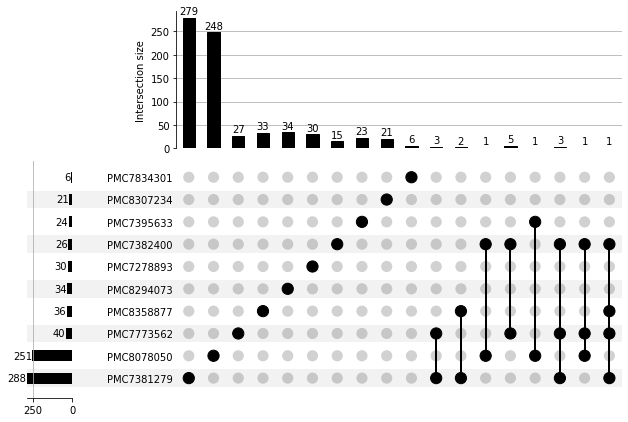

In [44]:
UpSet(mirnaMems, subset_size='count', show_counts=True).plot()

In [67]:
class ViralAccessionDB:

    def __init__(self, path="/mnt/raidtmp/joppich/pubmed_pmc/pmc/vimtm/data/viral_genomes_accessions.tsv", taxonomy_nodes="../nodes.dmp", taxonomy_merges="../merged.dmp", doc2tax="../doc2tax"):

        self.db = {}
        df = pd.read_csv(path, sep="\t", comment="#", header=None)
        df.columns = ["Representative","Neighbor","Host","Selected lineage","Taxonomy name","Segment name"]

        for ri, row in df.iterrows():
            for rep in row["Representative"].split(","):
                self.db[rep] = (row["Selected lineage"], row["Taxonomy name"])

        self.taxOntology = GeneOntology()

        with open(taxonomy_nodes) as fin:
            allTerms = []
            for line in fin:
                line = line.strip().split("|")

                taxid = line[0].strip()
                parent_taxid = line[1].strip()

                taxTerm = GOTerm()
                taxTerm.id = taxid
                taxTerm.name = taxid
                isaRelation = GORelation(GORelationType['IS_A'], termid=parent_taxid)
                taxTerm.is_a = [isaRelation]

                allTerms.append(taxTerm)

            self.taxOntology.addterms(allTerms)

        with open(taxonomy_merges) as fin:
            allTerms = []
            for line in fin:
                line = line.strip().split("|")

                taxid = line[0].strip()
                new_taxid = line[1].strip()

                taxTerm = GOTerm()
                taxTerm.id = taxid
                taxTerm.name = taxid
                isaRelation = GORelation(GORelationType['IS_A'], termid=new_taxid)
                taxTerm.is_a = [isaRelation]

                allTerms.append(taxTerm)

            self.taxOntology.addterms(allTerms)


        self.doc2tax = defaultdict(set)
        with open(doc2tax) as fin:
            for line in fin:
                line = line.strip().split("\t")
                self.doc2tax[line[0]].add(line[1])

    def annotate_virus_seq_name(self, mbo):
        for origin in mbo:
            for x in mbo[origin]:
                if "virus" in x.bestmatches:
                    mirnaMatchID = x.bestmatches["virus"]["matched_seq_id"]
                    x.bestmatches["virus"]["matched_seq_name"] = self.db.get(mirnaMatchID, None)

                    for hi in range(len(x.bestmatches["virus"]["allhits"])):
                        x.bestmatches["virus"]["allhits"][hi]["matched_seq_name"] = self.db.get(     x.bestmatches["virus"]["allhits"][hi]["matched_seq_id"], None)


    def annotate_matching_taxids(self, mbo):

        for x in mbo:

            for mirna in mbo[x]:
                
                mirna.bestmatches["virus"]["matched_doc_virus"] = []

                for bestMatchID, mirnaHit in enumerate(mirna.bestmatches["virus"]["allhits"]):

                    mirnaVirusTaxID = mirnaHit["matched_tax_id"]       
                    bTaxTerm = self.taxOntology.getID(mirnaVirusTaxID)

                    virusTaxIDs = set([bTaxTerm.id]) #set([str(x.termid) for x in bTaxTerm.getAllChildren(includeTerm=True)])
                    docTaxIDs = self.doc2tax.get(x, [])
                    
                    docMatchesVirus = False
                    docChildTaxIDs = []
                    dTaxID = None

                    for dTaxID in docTaxIDs:
                        dTaxTerm = self.taxOntology.getID(dTaxID)

                        if dTaxTerm is None:
                            print("Unknown TaxID from Document", dTaxID)
                            continue
                        
                        docChildTaxIDs = set([str(x.termid) for x in dTaxTerm.getAllChildren(includeTerm=True)])
                        
                        if len(virusTaxIDs.intersection(docChildTaxIDs)) > 0:
                            docMatchesVirus = True
                            break

                    #print(x, mirna.mirna_seq, bestMatchID, dTaxID, mirnaVirusTaxID, docMatchesVirus)

                    taxIntersection = virusTaxIDs.intersection(docChildTaxIDs)
                    intersectionSize = len(taxIntersection)

                    if len(mirna.bestmatches["virus"]["matched_doc_virus"]) == 0 and not dTaxID is None:
                        mirna.bestmatches["virus"]["matched_doc_virus"] = set([dTaxID]) #taxIntersection
                    

In [68]:
vaDB = ViralAccessionDB()

no parent 0
no parent 0


In [69]:
vaDB.annotate_virus_seq_name(mirnasByOrigin)
vaDB.annotate_matching_taxids(mirnasByOrigin)

Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID from Document 11119
Unknown TaxID 

In [70]:
for x in sorted(mirnasByOrigin):
    print(x, vaDB.doc2tax.get(x, "-"))

PMC7278893 {'11119', '227859', '2697049'}
PMC7381279 {'227859', '2697049'}
PMC7382400 {'11119', '2697049'}
PMC7395633 {'2697049'}
PMC7773562 {'11119', '227859', '2697049'}
PMC7834301 -
PMC8078050 {'227859', '2697049', '1335626'}
PMC8294073 {'11119', '2697049'}
PMC8307234 {'227859', '2697049'}
PMC8358877 {'186536', '11119', '2697049'}
UNKNOWN -


In [71]:
list(mirnasByOrigin["PMC8078050"])[1].__dict__

{'mirna_id': 'SARS-CoV-2-miR-078',
 'mirna_seq': 'AUUAUUCUUACAAAGUUUAUAC',
 'origin': ['PMC8078050'],
 'source': 'SEQ_COLUMN',
 'bestmatches': {'virus': {'matches': 22,
   'mirna_len': 22,
   'acc': 1.0,
   'matched_seq_id': 'gi|1798174254|ref|NC_045512',
   'matched_tax_id': '2697049',
   'allhits': [{'matches': 22,
     'mirna_len': 22,
     'acc': 1.0,
     'matched_seq_id': 'gi|1798174254|ref|NC_045512',
     'matched_tax_id': '2697049',
     'matched_seq_name': None}],
   'matched_seq_name': None,
   'matched_doc_virus': {'2697049'}}}}

In [72]:
matchedCount = 0
matchedMirnas = set()
tax2mirnas = defaultdict(set)
tax2mirnaseq = defaultdict(set)

origin2tax2mirna = defaultdict(lambda: defaultdict(set))

for x in mirnasByOrigin:

    for mirna in mirnasByOrigin[x]:
        
        if len(mirna.bestmatches["virus"]["matched_doc_virus"]) > 0:
            matchedCount += 1
            matchedMirnas.add(mirna.mirna_seq)

            for taxID in mirna.bestmatches["virus"]["matched_doc_virus"]:
                tax2mirnas[taxID].add(mirna)
                tax2mirnaseq[taxID].add(mirna.mirna_seq)

                for docID in mirna.origin:
                    origin2tax2mirna[docID][taxID].add(mirna.mirna_seq)

print(matchedCount)
print(len(matchedMirnas))

for taxID in tax2mirnas:
    print(taxID, len(tax2mirnas[taxID]), len(tax2mirnaseq[taxID]))

1406
1114
2697049 742 596
1335626 664 518


In [73]:
for docID in sorted(origin2tax2mirna):
    for taxID in origin2tax2mirna[docID]:
        print(docID, taxID, len(origin2tax2mirna[docID][taxID]))

PMC7278893 2697049 30
PMC7381279 2697049 288
PMC7382400 2697049 26
PMC7395633 2697049 24
PMC7773562 2697049 40
PMC8078050 1335626 518
PMC8078050 2697049 120
PMC8294073 2697049 34
PMC8307234 2697049 21
PMC8358877 2697049 36


In [75]:
tax2mirnas["1335626"].intersection(tax2mirnas["2697049"])

set()

In [77]:
for x in tax2mirnaseq:
    print(x, len(tax2mirnaseq[x]))

2697049 596
1335626 518
